# Model Ranking and Select the Best Model

- Aggregates evaluation results from all trained models - 
    - Logistic Regression (GridSearchCV Optimization)
    - Random Forest (GridSearchCV Optimization)
    - Support Vector Classifier (BayesSearchCV Optimization)
    - LightGBM (Optuna Optimization)
    - XGBoost (Optuna Optimization)
    - Neural Network (Fixed Architecture)

- compares their performance metrics
- and identifies the best-performing model. 

Once the best model is selected, we'll performs error analysis and visualizes performance through plots.

Purpose:
- Provide a unified comparison of all candidate models
- Select the most suitable model for deployment
- Conduct error analysis and performance visualization for the chosen model


# Import Libraries

In [1]:
# dataframe and calculation
import pandas as pd
import numpy as np

# visualization graphs
import matplotlib.pyplot as plt
import seaborn as sns

# advanced visualization
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import shap

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# persist model
from pathlib import Path
import joblib
import pickle

c:\Users\Tshihab07\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Models Performance and Artifacts

In [2]:
""" File and Artifacts Directories """

# dataset path
file = Path(r"../data/CleanedLoanData.csv")

# artifacts path
artifacts_dir = Path(r"../artifacts/feature-selection")

# model performance path
model_performance_dir = Path(r"../artifacts/model-performance")

# models path
model_dir = Path(r"../artifacts/models")

In [3]:
# load artifacts
x_train = joblib.load(artifacts_dir / "x_train.pkl")
x_train_scale = joblib.load(artifacts_dir / "x_train_scaler.pkl")
x_test = joblib.load(artifacts_dir / "x_test.pkl")
x_test_scale = joblib.load(artifacts_dir / "x_test_scaler.pkl")
y_train = joblib.load(artifacts_dir / "y_train.pkl")
y_test = joblib.load(artifacts_dir / "y_test.pkl")

cv = joblib.load(artifacts_dir / "cv.pkl")

# configure socring metrics
scoring_metrics = 'roc_auc'

In [4]:
# load model performance results
model_performance = pd.read_csv(model_performance_dir / "a_ModelsPerformance.csv")
cv_scores = pd.read_csv(model_performance_dir / "a_CrossValidationScore.csv")
model_scores = pd.read_csv(model_performance_dir / "a_ModelsScores.csv")
overfitting_analysis = pd.read_csv(model_performance_dir / "a_OverfittingAnalysis.csv")

# Model Results Overview

In [5]:
# Table 1: Cross-Validation Score
print("=== TABLE 1: CROSS-VALIDATION SCORE (All Models) ===")
display(cv_scores)

=== TABLE 1: CROSS-VALIDATION SCORE (All Models) ===


,Model,CV Mean,CV Std
0,Neural Network,0.698,0.091
1,XGBoost (Optuna),0.776,0.038
2,LightGBM (Optuna),0.773,0.027
3,SVC (BayesSearchCV),0.478,0.026
4,Random Forest (GridSearchCV),0.778,0.034
5,Logistic Regression (GridSearchCV),0.776,0.028


In [6]:
# Table 2: Overfitting Analysis
print("=== TABLE 2: OVERFITTING ANALYSIS ===".center(140))
display(overfitting_analysis)

                                                   === TABLE 2: OVERFITTING ANALYSIS ===                                                    


,Model,AUC-ROC Gap,AUC-PR Gap,Precision Gap,Recall Gap,F1-Score Gap,Accuracy Gap,Overfitting Status
0,Neural Network,0.033,0.014,0.063,0.009,0.041,0.069,Low
1,XGBoost (Optuna),0.009,0.005,0.043,0.021,0.034,0.057,Low
2,LightGBM (Optuna),0.041,0.024,0.041,0.012,0.018,0.032,Low
3,SVC (BayesSearchCV),0.005,0.013,0.004,0.050,0.036,0.030,Low
4,Random Forest (GridSearchCV),0.036,0.027,0.014,0.036,0.008,0.007,Low
5,Logistic Regression (GridSearchCV),0.102,0.065,0.068,0.003,0.036,0.059,Low


In [7]:
# Table 3: Model Scores (Composite + Metrics)
print("=== TABLE 3: MODEL SCORES ===".center(130))
display(model_scores)

                                                  === TABLE 3: MODEL SCORES ===                                                   


,Model,CV Mean,CV Std,Test Accuracy,Test F1-Score,Test AUC,Overfitting Gap,Composite Score
0,Neural Network,0.698,0.091,0.878,0.917,0.845,0.033,0.838
1,XGBoost (Optuna),0.776,0.038,0.854,0.903,0.865,0.009,0.869
2,LightGBM (Optuna),0.773,0.027,0.837,0.885,0.855,0.041,0.860
3,SVC (BayesSearchCV),0.478,0.026,0.667,0.705,0.837,0.005,0.720
4,Random Forest (GridSearchCV),0.778,0.034,0.846,0.891,0.875,0.036,0.866
5,Logistic Regression (GridSearchCV),0.776,0.028,0.821,0.867,0.879,0.102,0.853


In [8]:
# Table 1: All Models Performance
print("=== TABLE 4: OVERALL MODELS PERFORMANCE ===".center(140))
display(model_performance)

                                                === TABLE 4: OVERALL MODELS PERFORMANCE ===                                                 


,Model,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Accuracy,CV AUC-ROC Mean,CV AUC-ROC Std,AUC-ROC (Overfit) Gap,Composite Score,Overfitting Status,Model Status
0,Neural Network,0.845,0.884,0.856,0.988,0.917,0.878,0.698,0.091,0.033,0.838,Low,Good
1,XGBoost (Optuna),0.865,0.924,0.824,1.000,0.903,0.854,0.776,0.038,0.009,0.869,Low,Good
2,LightGBM (Optuna),0.855,0.917,0.856,0.917,0.885,0.837,0.773,0.027,0.041,0.860,Low,Fair
3,SVC (BayesSearchCV),0.837,0.879,0.891,0.583,0.705,0.667,0.478,0.026,0.005,0.720,Low,Needs Improvement
4,Random Forest (GridSearchCV),0.875,0.927,0.857,0.929,0.891,0.846,0.778,0.034,0.036,0.866,Low,Fair
5,Logistic Regression (GridSearchCV),0.879,0.923,0.878,0.857,0.867,0.821,0.776,0.028,0.102,0.853,Low,Fair


In [9]:
# models ranking based on composite score, CV Mean and AUC-ROC
model_ranking = model_performance.sort_values(by=['Composite Score', 'CV AUC-ROC Mean', 'AUC-ROC'], ascending=False).reset_index(drop=True)

print("=== TABLE 5: MODELS RANKING ===".center(140))
display(model_ranking)

                                                      === TABLE 5: MODELS RANKING ===                                                       


,Model,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Accuracy,CV AUC-ROC Mean,CV AUC-ROC Std,AUC-ROC (Overfit) Gap,Composite Score,Overfitting Status,Model Status
0,XGBoost (Optuna),0.865,0.924,0.824,1.000,0.903,0.854,0.776,0.038,0.009,0.869,Low,Good
1,Random Forest (GridSearchCV),0.875,0.927,0.857,0.929,0.891,0.846,0.778,0.034,0.036,0.866,Low,Fair
2,LightGBM (Optuna),0.855,0.917,0.856,0.917,0.885,0.837,0.773,0.027,0.041,0.860,Low,Fair
3,Logistic Regression (GridSearchCV),0.879,0.923,0.878,0.857,0.867,0.821,0.776,0.028,0.102,0.853,Low,Fair
4,Neural Network,0.845,0.884,0.856,0.988,0.917,0.878,0.698,0.091,0.033,0.838,Low,Good
5,SVC (BayesSearchCV),0.837,0.879,0.891,0.583,0.705,0.667,0.478,0.026,0.005,0.720,Low,Needs Improvement


# Threshold Optimization of Best Model

In [10]:
# select best model
best_model = model_ranking.iloc[0]['Model']
print("Overall Best Model: ", best_model)

Overall Best Model:  XGBoost (Optuna)


# Threshold Optimization

In [11]:
# load test probabilities
test_proba = np.load(model_dir / "xgboost_testProba.npy")

In [12]:
# Optimize for F1-Score
precision_curve, recall_curve, thresold_pr = precision_recall_curve(y_test, test_proba)
f1 = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
optimize_idx = np.argmax(f1)
optimal_threshold = thresold_pr[optimize_idx]

In [13]:
print(f"THRESHOLD OPTIMIZATION FOR {best_model}")
print(f"Optimal Threshold (Max F1): {optimal_threshold:.3f}")
print(f"F1 at Optimal Threshold: {f1[optimize_idx]:.3f}")

THRESHOLD OPTIMIZATION FOR XGBoost (Optuna)
Optimal Threshold (Max F1): 0.618
F1 at Optimal Threshold: 0.907


## PR Curve

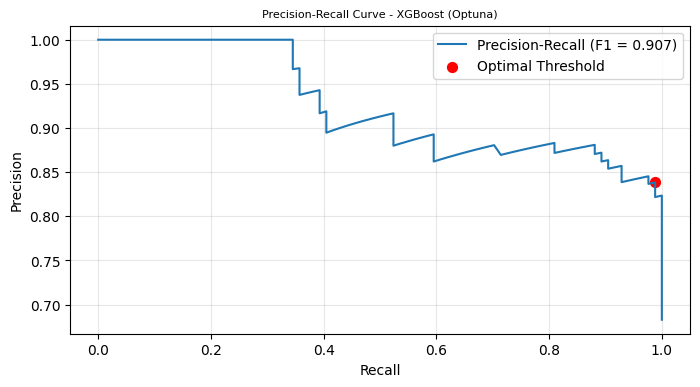

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall (F1 = {f1[optimize_idx]:.3f})')
plt.scatter(recall_curve[optimize_idx], precision_curve[optimize_idx], color='red', s=50, label='Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model}', fontsize=8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()